# Coin flip example QRBM
In this demo we will go over a simple use case for an RBM that is trained semi-classically, semi-quantumly. To get started, we import our dependencies, we will need pyquil, grove, numpy and scipy. 

In [1]:
import pyquil.api as api
from pyquil import Program
from qRBM_final import qRBM
from pyquil.gates import *
from random import *
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import log_loss 

## Utility functions

In [100]:
def train(num_epochs=20, gate_noise_probs=None, meas_noise_probs=None, n_quantum_measurements=None):
    '''
    gate_noise_probs:       PX, PY, PZ gates getting applied to each qubit after every gate application
    meas_noise_probs:       PX, PY, PZ gates getting applied to the qubit being measured before it is measured
    n_quantum_measurements: None means "analytical" measurement to save time on simulation

    '''
    qvm = api.QVMConnection(gate_noise=gate_noise_probs, measurement_noise=meas_noise_probs)
    qr = qRBM(qvm, num_visible=4, num_hidden=1, n_quantum_measurements=n_quantum_measurements)
    qr.train(artificial_data, n_epochs=num_epochs)
    return qr, get_log_loss_list(qr, num_epochs)

In [68]:
def get_log_loss_list(qr, num_epochs):
    log_loss_list = []
    for epoch in range(num_epochs):
        log_loss_list.append(log_loss(random_coin, qr.pred_list[epoch], eps=1e-15))
    return log_loss_list

In [69]:
def plot_loss(log_loss_list):
    plt.plot(log_loss_list)
    # plt.ylim(0, 1)
    plt.xlabel('epochs')
    plt.ylabel('Binary Cross-entropy')
    plt.title('Binary Cross-entropy loss across epochs') 

In [70]:
def show_probs(qr):
    transformed = qr.transform(artificial_data)

    comparison = np.stack((transformed[:,0], random_coin))

    #compare our rbm probabilities with the coin flips.
    print('RBM Pr. | Original Coin Value')
    # print '-'*20
    for i in range(len(transformed)):
        print('{: 0.3f}'.format(float(comparison[:,i][0])), ' |', '{: 0.3f}'.format(comparison[:,i][1]))

## Creating the underlying distribution
We flip an unbiased coin to generate a sequence of random bits, this will be the underlying hidden distribution of our data.

In [71]:
#flip a coin
np.random.seed(1234)
random_coin = np.random.choice([0,1], size=20, replace=True)
random_coin

array([1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0])

## Generating encoded sequences
Code below takes our sequence of random bits and encodes each 1 bit result into a 4 bit representation. This effectively creates artificial data with a 1 bit "needle" (hidden code subspace) in the "haystack" (4-bit data), which our RBM will have to decode. 

In [72]:
#Encode this coin flip in to an artifically high dimensional dataset
artificial_data = []
for flip in random_coin:
    if flip == 1:
        artificial_data.append([-1,-1,1,1]) 
    else:
        artificial_data.append([1,1,-1,-1]) 

#We know have an artificially high dimensional dataset that still only has the 1 bit coin flip dictating
#the underlying distribution
artificial_data = np.asarray(artificial_data)
artificial_data.shape

(20, 4)

# Noiseless QVM

In [117]:
%%capture
model, log_loss_list = train(num_epochs=20, n_quantum_measurements=5)

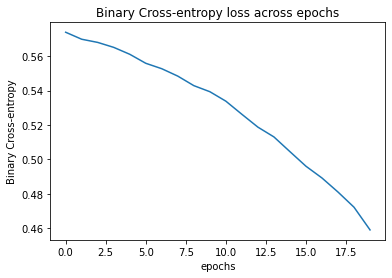

In [118]:
plot_loss(log_loss_list)

In [119]:
show_probs(model)

RBM Pr. | Original Coin Value
 0.632  |  1.000
 0.632  |  1.000
 0.368  |  0.000
 0.632  |  1.000
 0.368  |  0.000
 0.368  |  0.000
 0.368  |  0.000
 0.632  |  1.000
 0.632  |  1.000
 0.632  |  1.000
 0.632  |  1.000
 0.632  |  1.000
 0.368  |  0.000
 0.368  |  0.000
 0.632  |  1.000
 0.368  |  0.000
 0.368  |  0.000
 0.368  |  0.000
 0.368  |  0.000
 0.368  |  0.000


# QVM gate noise

### [PX, PY, PZ] = [0.2, 0, 0], worse performance than noiseless QC

In [108]:
%%capture
# 20% chance of a X gate being applied after gate applications and before measurements.
gate_noise_probs=[0.2, 0.0, 0.0] # [PX, PY, PZ]
model, log_loss_list = train(num_epochs=20, 
                             gate_noise_probs=gate_noise_probs,
                             n_quantum_measurements=5)

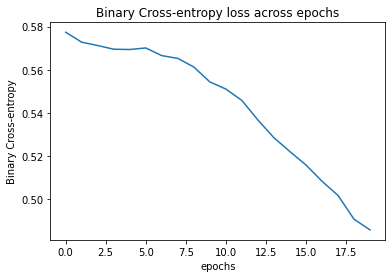

In [109]:
plot_loss(log_loss_list)

In [110]:
show_probs(model)

RBM Pr. | Original Coin Value
 0.615  |  1.000
 0.615  |  1.000
 0.385  |  0.000
 0.615  |  1.000
 0.385  |  0.000
 0.385  |  0.000
 0.385  |  0.000
 0.615  |  1.000
 0.615  |  1.000
 0.615  |  1.000
 0.615  |  1.000
 0.615  |  1.000
 0.385  |  0.000
 0.385  |  0.000
 0.615  |  1.000
 0.385  |  0.000
 0.385  |  0.000
 0.385  |  0.000
 0.385  |  0.000
 0.385  |  0.000


### [PX, PY, PZ] = [0, 0, 0.2], similar performance as PX noise

In [111]:
%%capture
gate_noise_probs=[0., 0., 0.2] # [PX, PY, PZ]
model, log_loss_list = train(num_epochs=20, 
                             gate_noise_probs=gate_noise_probs,
                            n_quantum_measurements=5)

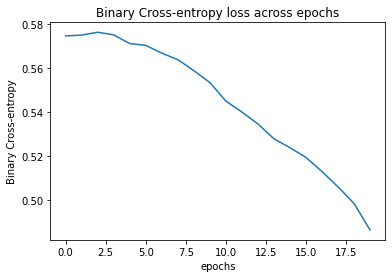

In [112]:
plot_loss(log_loss_list)

In [113]:
show_probs(model)

RBM Pr. | Original Coin Value
 0.615  |  1.000
 0.615  |  1.000
 0.385  |  0.000
 0.615  |  1.000
 0.385  |  0.000
 0.385  |  0.000
 0.385  |  0.000
 0.615  |  1.000
 0.615  |  1.000
 0.615  |  1.000
 0.615  |  1.000
 0.615  |  1.000
 0.385  |  0.000
 0.385  |  0.000
 0.615  |  1.000
 0.385  |  0.000
 0.385  |  0.000
 0.385  |  0.000
 0.385  |  0.000
 0.385  |  0.000


### [PX, PY, PZ] = [0, 0.2, 0], better performance than PX,PZ noise

In [114]:
%%capture
gate_noise_probs=[0., 0.2, 0.] # [PX, PY, PZ]
model, log_loss_list = train(num_epochs=20, 
                             gate_noise_probs=gate_noise_probs,
                            n_quantum_measurements=5)

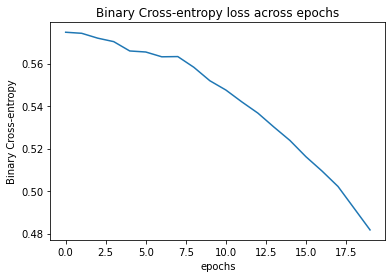

In [115]:
plot_loss(log_loss_list)

In [116]:
show_probs(model)

RBM Pr. | Original Coin Value
 0.618  |  1.000
 0.618  |  1.000
 0.382  |  0.000
 0.618  |  1.000
 0.382  |  0.000
 0.382  |  0.000
 0.382  |  0.000
 0.618  |  1.000
 0.618  |  1.000
 0.618  |  1.000
 0.618  |  1.000
 0.618  |  1.000
 0.382  |  0.000
 0.382  |  0.000
 0.618  |  1.000
 0.382  |  0.000
 0.382  |  0.000
 0.382  |  0.000
 0.382  |  0.000
 0.382  |  0.000


### [PX, PY, PZ] = [0.2, 0.2, 0.2]

In [120]:
%%capture
gate_noise_probs=[0.2, 0.2, 0.2] # [PX, PY, PZ]
model, log_loss_list = train(num_epochs=20, 
                             gate_noise_probs=gate_noise_probs,
                            n_quantum_measurements=5)

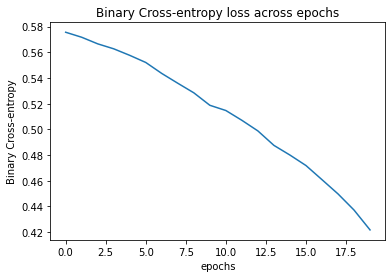

In [121]:
plot_loss(log_loss_list)

In [122]:
show_probs(model)

RBM Pr. | Original Coin Value
 0.656  |  1.000
 0.656  |  1.000
 0.344  |  0.000
 0.656  |  1.000
 0.344  |  0.000
 0.344  |  0.000
 0.344  |  0.000
 0.656  |  1.000
 0.656  |  1.000
 0.656  |  1.000
 0.656  |  1.000
 0.656  |  1.000
 0.344  |  0.000
 0.344  |  0.000
 0.656  |  1.000
 0.344  |  0.000
 0.344  |  0.000
 0.344  |  0.000
 0.344  |  0.000
 0.344  |  0.000


# QVM measurement noise

### [PX, PY, PZ] = [0.2, 0, 0], worse performance than gate noise

In [140]:
%%capture
meas_noise_probs = [0.2, 0.0, 0.0]
model, log_loss_list = train(num_epochs=20, 
                             meas_noise_probs=meas_noise_probs,
                            n_quantum_measurements=5)

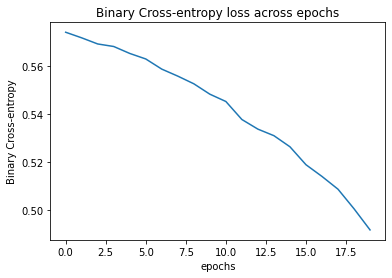

In [124]:
plot_loss(log_loss_list)

In [125]:
show_probs(model)

RBM Pr. | Original Coin Value
 0.612  |  1.000
 0.612  |  1.000
 0.388  |  0.000
 0.612  |  1.000
 0.388  |  0.000
 0.388  |  0.000
 0.388  |  0.000
 0.612  |  1.000
 0.612  |  1.000
 0.612  |  1.000
 0.612  |  1.000
 0.612  |  1.000
 0.388  |  0.000
 0.388  |  0.000
 0.612  |  1.000
 0.388  |  0.000
 0.388  |  0.000
 0.388  |  0.000
 0.388  |  0.000
 0.388  |  0.000


### [PX, PY, PZ] = [0, 0.2, 0], worse performance than noiseless

In [137]:
%%capture
meas_noise_probs = [0., 0.2, 0.0]
model, log_loss_list = train(num_epochs=20, 
                             meas_noise_probs=meas_noise_probs,
                            n_quantum_measurements=5)

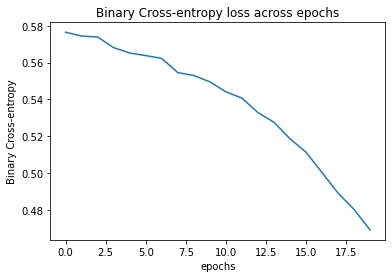

In [138]:
plot_loss(log_loss_list)

In [139]:
show_probs(model)

RBM Pr. | Original Coin Value
 0.626  |  1.000
 0.626  |  1.000
 0.374  |  0.000
 0.626  |  1.000
 0.374  |  0.000
 0.374  |  0.000
 0.374  |  0.000
 0.626  |  1.000
 0.626  |  1.000
 0.626  |  1.000
 0.626  |  1.000
 0.626  |  1.000
 0.374  |  0.000
 0.374  |  0.000
 0.626  |  1.000
 0.374  |  0.000
 0.374  |  0.000
 0.374  |  0.000
 0.374  |  0.000
 0.374  |  0.000


### [PX, PY, PZ] = [0, 0, 0.2], worse performance than noiseless

In [131]:
%%capture
meas_noise_probs = [0., 0., 0.2]
model, log_loss_list = train(num_epochs=20, 
                             meas_noise_probs=meas_noise_probs,
                            n_quantum_measurements=5)

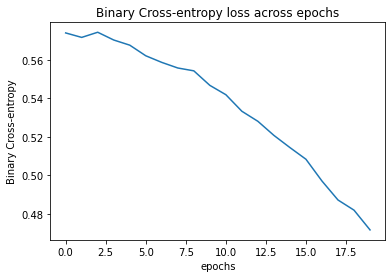

In [132]:
plot_loss(log_loss_list)

In [133]:
show_probs(model)

RBM Pr. | Original Coin Value
 0.624  |  1.000
 0.624  |  1.000
 0.376  |  0.000
 0.624  |  1.000
 0.376  |  0.000
 0.376  |  0.000
 0.376  |  0.000
 0.624  |  1.000
 0.624  |  1.000
 0.624  |  1.000
 0.624  |  1.000
 0.624  |  1.000
 0.376  |  0.000
 0.376  |  0.000
 0.624  |  1.000
 0.376  |  0.000
 0.376  |  0.000
 0.376  |  0.000
 0.376  |  0.000
 0.376  |  0.000


### [PX, PY, PZ] = [0.2, 0.2, 0.2], worse performance than noiseless

In [134]:
%%capture
meas_noise_probs = [0.2, 0.2, 0.2]
model, log_loss_list = train(num_epochs=20, 
                             meas_noise_probs=meas_noise_probs,
                            n_quantum_measurements=5)

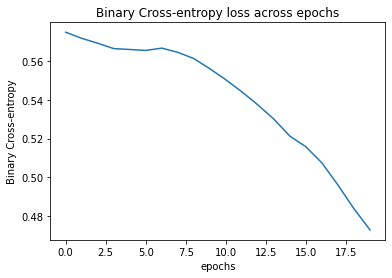

In [135]:
plot_loss(log_loss_list)

In [136]:
show_probs(model)

RBM Pr. | Original Coin Value
 0.623  |  1.000
 0.623  |  1.000
 0.377  |  0.000
 0.623  |  1.000
 0.377  |  0.000
 0.377  |  0.000
 0.377  |  0.000
 0.623  |  1.000
 0.623  |  1.000
 0.623  |  1.000
 0.623  |  1.000
 0.623  |  1.000
 0.377  |  0.000
 0.377  |  0.000
 0.623  |  1.000
 0.377  |  0.000
 0.377  |  0.000
 0.377  |  0.000
 0.377  |  0.000
 0.377  |  0.000
